<a href="https://colab.research.google.com/github/Tan-Yu/GWU_NN/blob/main/GWU_NN_Project_To_Be_Submitted.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Detection: Furniture

In [37]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="7qWbVQEyrrOmqn5a34Ik")
project = rf.workspace("roboflow-100").project("furniture-ngpea")
dataset = project.version(2).download("tensorflow")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to furniture-2 in tensorflow:: 100%|██████████| 697/697 [00:00<00:00, 2638.80it/s]


# Import Libraries

In [38]:
import cv2
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, Add, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers.schedules import ExponentialDecay



# Data Preparation

In [39]:


# Set the path to your dataset
data_path = "/content/furniture-2"

# Load annotations from CSV files
train_annotations = pd.read_csv(os.path.join(data_path, "train", "_annotations.csv"))
valid_annotations = pd.read_csv(os.path.join(data_path, "valid", "_annotations.csv"))

# Rescale bounding box coordinates based on the new image size
def rescale_bbox(row):
    width_ratio = 300 / row['width']
    height_ratio = 300 / row['height']
    row['xmin'] *= width_ratio
    row['xmax'] *= width_ratio
    row['ymin'] *= height_ratio
    row['ymax'] *= height_ratio
    return row

train_annotations = train_annotations.apply(rescale_bbox, axis=1)
valid_annotations = valid_annotations.apply(rescale_bbox, axis=1)

# Create an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(rescale=1./255)

# Create custom data generators
train_generator = datagen.flow_from_dataframe(
    dataframe=train_annotations,
    directory=os.path.join(data_path, "train"),
    x_col="filename",
    y_col=["xmin", "ymin", "xmax", "ymax"],
    target_size=(300, 300),
    batch_size=32,
    class_mode="raw",
    # subset="training"
)

valid_generator = datagen.flow_from_dataframe(
    dataframe=valid_annotations,
    directory=os.path.join(data_path, "valid"),
    x_col="filename",
    y_col=["xmin", "ymin", "xmax", "ymax"],
    target_size=(300, 300),
    batch_size=32,
    class_mode="raw",
    # subset="validation"
)


Found 454 validated image filenames.
Found 161 validated image filenames.




---



# Model \#1

1. **Input Layer:**
   - Input shape: (300, 300, 3) representing a 300x300 pixel image with 3 color channels (RGB).

2. **Convolutional Layers:**
   - Conv2D(64, (3, 3), activation='relu'): 64 filters of size 3x3, ReLU activation.
   - MaxPooling2D((2, 2)): Max pooling with a 2x2 pool size to down-sample the spatial dimensions.
   - Dropout(0.25): Regularization layer to prevent overfitting.

   - Conv2D(128, (3, 3), activation='relu'): 128 filters of size 3x3, ReLU activation.
   - MaxPooling2D((2, 2)): Max pooling for down-sampling.

   - Conv2D(256, (3, 3), activation='relu'): 256 filters of size 3x3, ReLU activation.
   - MaxPooling2D((2, 2)): Max pooling for down-sampling.

3. **Flatten Layer:**
   - Flattens the output from the previous layers into a 1D array to be fed into dense layers.

4. **Fully Connected (Dense) Layers:**
   - Dense(512, activation='relu'): 512 neurons with ReLU activation.
   - Dropout(0.5): Another dropout layer for regularization to further prevent overfitting.

5. **Output Layer:**
   - Dense(4, activation='linear'): Output layer with 4 neurons corresponding to bounding box coordinates (xmin, ymin, xmax, ymax) for regression. Linear activation is used since this is a regression task.

**Key Points:**
- Convolutional layers extract hierarchical features from the input image.
- Max pooling layers down-sample the spatial dimensions.
- Dropout layers help prevent overfitting.
- The final dense layers map the extracted features to bounding box coordinates.
- Smooth L1 loss is typically used for regression tasks like bounding box prediction.

This architecture aims to balance complexity for feature extraction and regularization to create an effective model for object detection tasks.

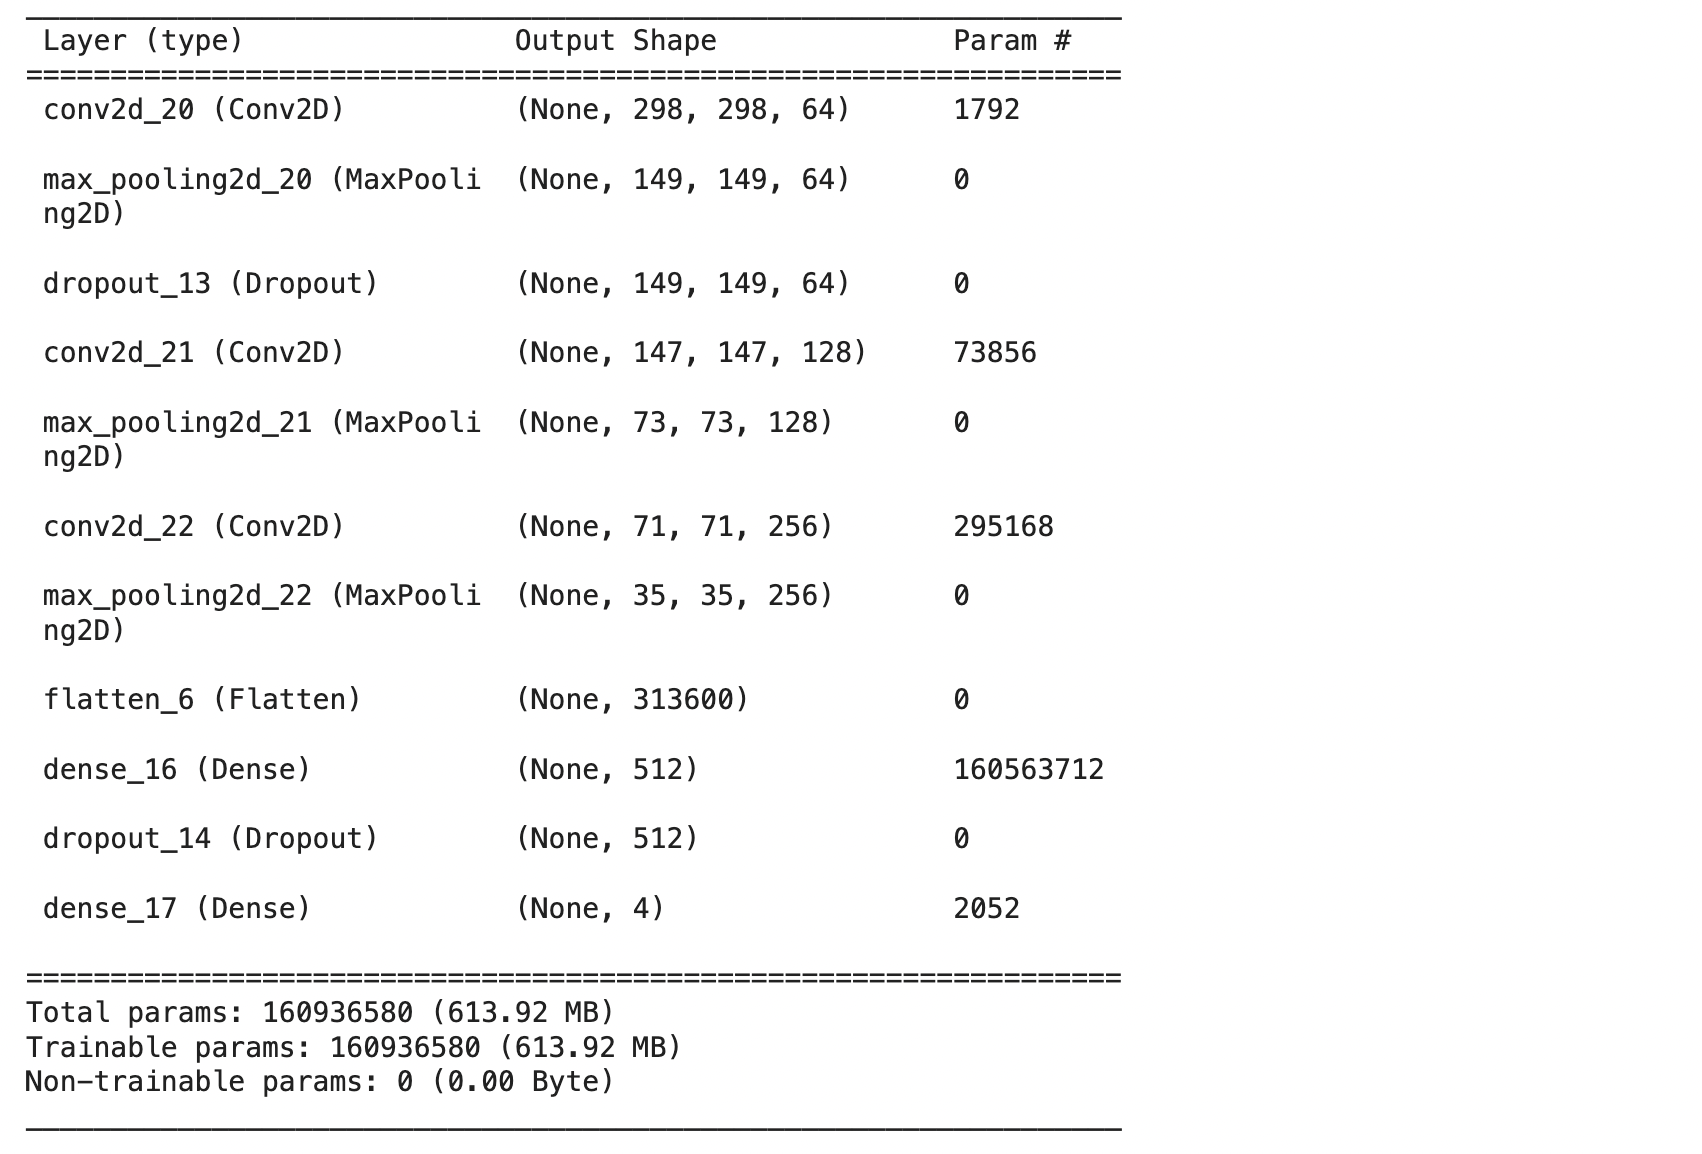

In [ ]:

# Define and compile the model with smooth L1 loss
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(300, 300, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='linear')
])

# Model #2

1. **Input Layer:**
   - Input shape: (300, 300, 3) representing a 300x300 pixel image with 3 color channels (RGB).

2. **Feature Extraction Backbone:**
   - Conv2D(32, (3, 3), activation='relu'): 32 filters of size 3x3, ReLU activation.
   - MaxPooling2D((2, 2)): Max pooling with a 2x2 pool size to down-sample the spatial dimensions.
   - Dropout(0.25): Regularization layer to prevent overfitting.

   - Conv2D(64, (3, 3), activation='relu'): 64 filters of size 3x3, ReLU activation.
   - MaxPooling2D((2, 2)): Max pooling for down-sampling.
   - Dropout(0.25): Regularization layer.

   - Conv2D(128, (3, 3), activation='relu'): 128 filters of size 3x3, ReLU activation.
   - MaxPooling2D((2, 2)): Max pooling for down-sampling.
   - Dropout(0.25): Regularization layer.

   - Conv2D(256, (3, 3), activation='relu'): 256 filters of size 3x3, ReLU activation.
   - MaxPooling2D((2, 2)): Max pooling for down-sampling.
   - Dropout(0.25): Regularization layer.

   - Conv2D(512, (3, 3), activation='relu'): 512 filters of size 3x3, ReLU activation.
   - MaxPooling2D((2, 2)): Max pooling for down-sampling.
   - Dropout(0.25): Regularization layer.

   - Conv2D(512, (3, 3), activation='relu'): Another set of 512 filters with ReLU activation.
   - MaxPooling2D((2, 2)): Max pooling for down-sampling.
   - Dropout(0.25): Regularization layer.

3. **Global Average Pooling Layer:**
   - GlobalAveragePooling2D(): Aggregates spatial information by computing the average of each feature map.

4. **Fully Connected (Dense) Layers:**
   - Dense(512, activation='relu'): 512 neurons with ReLU activation.
   - Dropout(0.5): Regularization layer to prevent overfitting.

5. **Output Layer:**
   - Dense(4, activation='linear'): Output layer with 4 neurons corresponding to bounding box coordinates (xmin, ymin, xmax, ymax) for regression. Linear activation is used since this is a regression task.

**Key Points:**
- The architecture uses multiple convolutional layers for hierarchical feature extraction.
- Dropout layers are employed for regularization.
- Global Average Pooling is used to reduce spatial dimensions before fully connected layers.
- Dense layers map the features to bounding box coordinates.
- Linear activation is used in the output layer for regression.

This architecture is designed for object detection with bounding box regression and emphasizes feature extraction through a deep convolutional backbone.

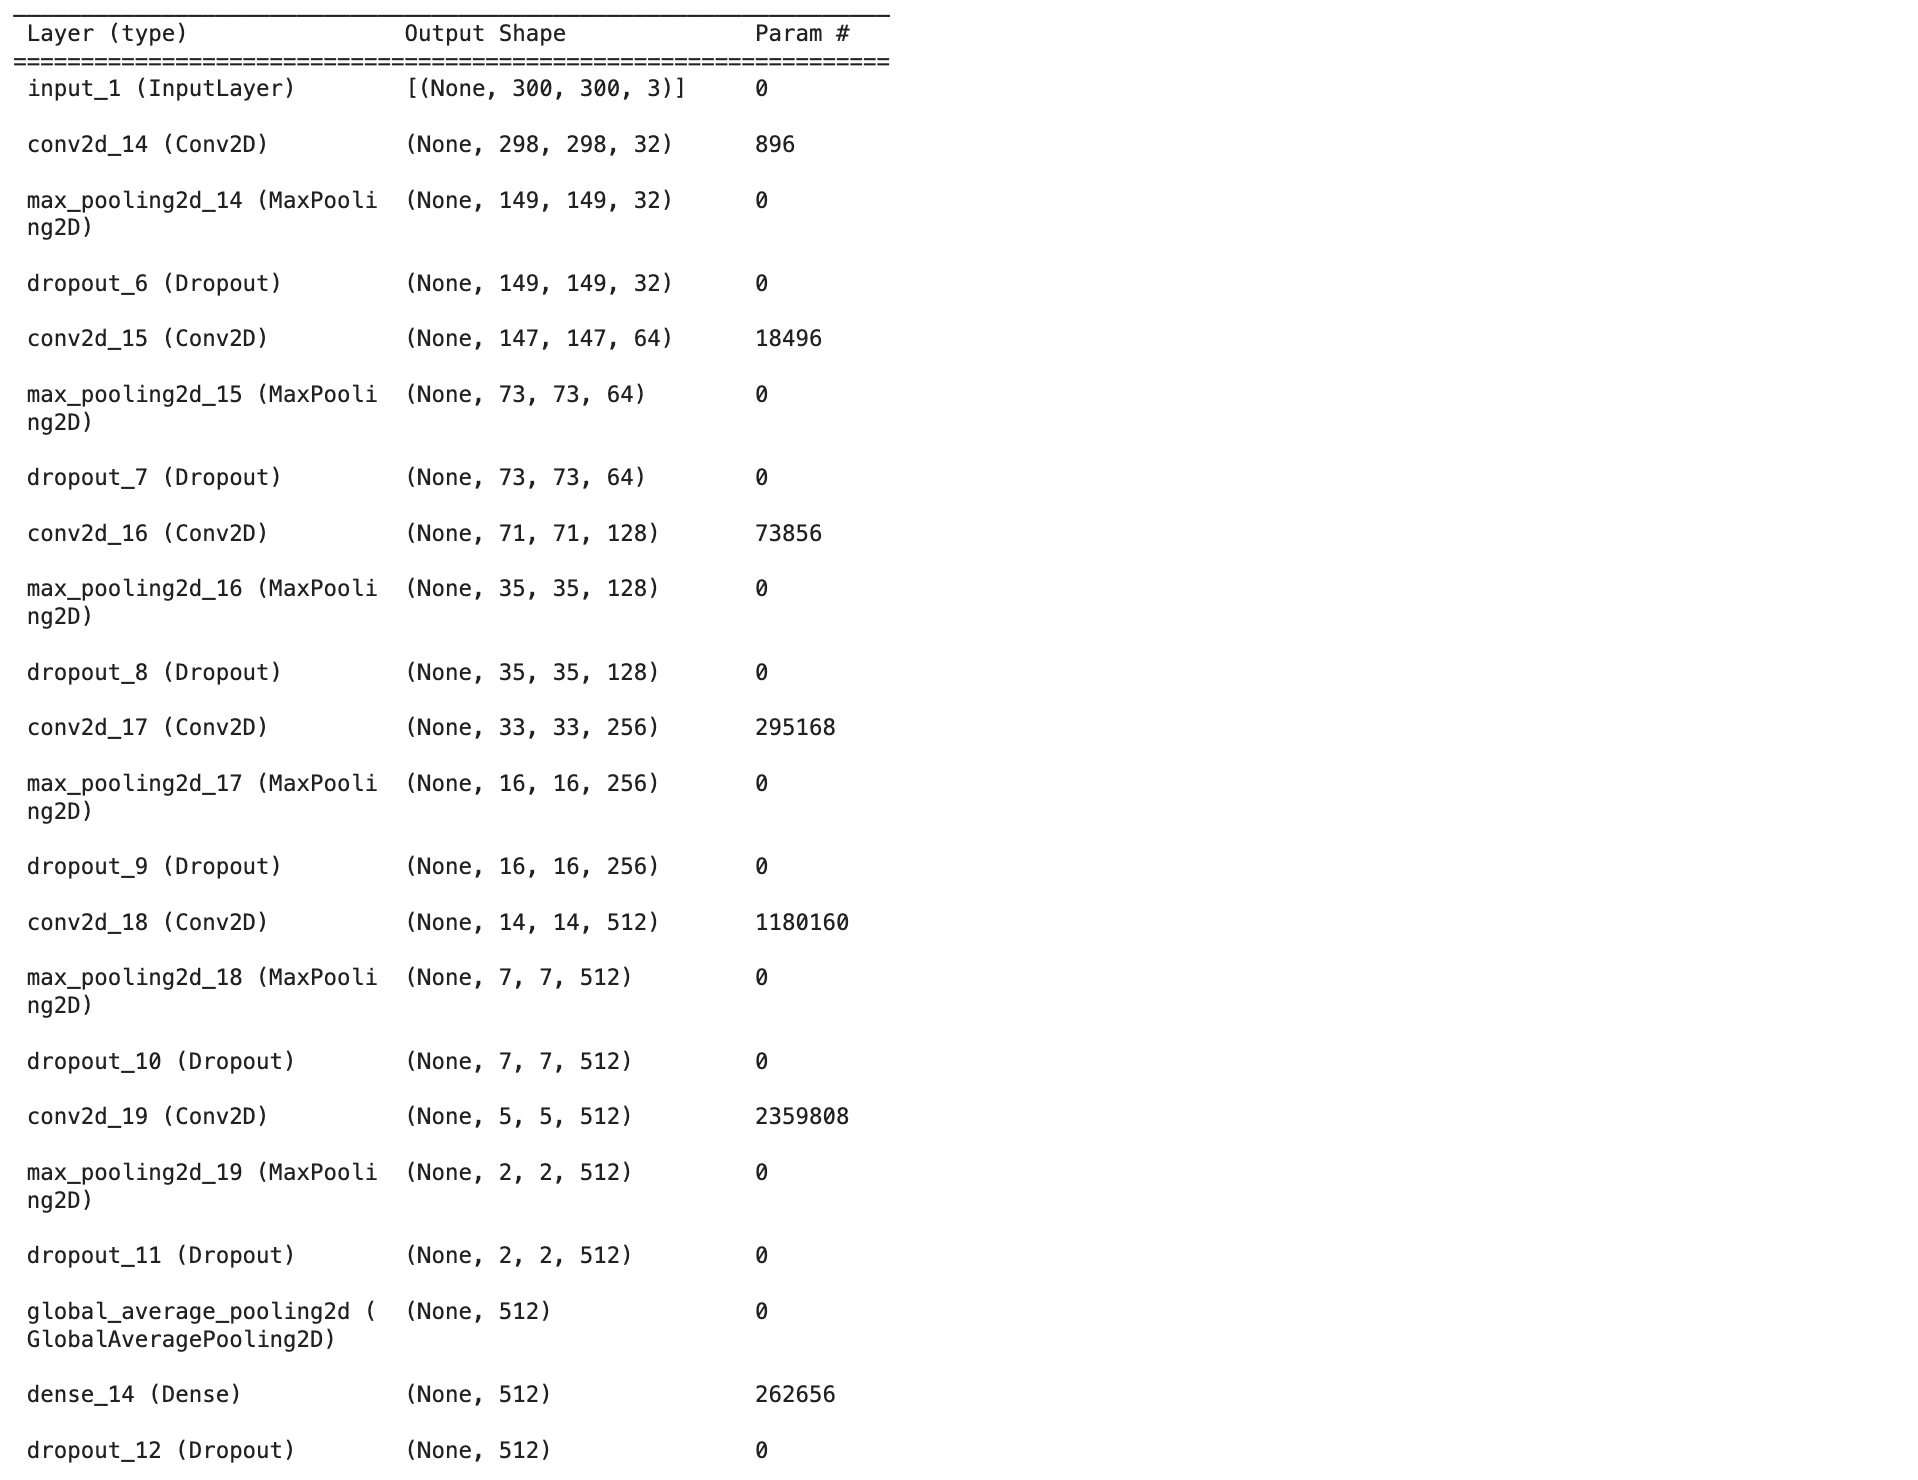
Screenshot 2023-11-18 at 12.18.03 AM.png

In [ ]:

# Define input layer
input_layer = Input(shape=(300, 300, 3))

# Feature extraction backbone
x = Conv2D(32, (3, 3), activation='relu')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.25)(x)

x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.25)(x)

x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.25)(x)

x = Conv2D(256, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.25)(x)

x = Conv2D(512, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.25)(x)

x = Conv2D(512, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.25)(x)

# Global average pooling layer
x = GlobalAveragePooling2D()(x)

# Fully connected layers
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)

# Output layer for bounding box regression
output_layer = Dense(4, activation='linear')(x)

# Create the model
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)


# Model \#3: Batch Normalization, and Regularization

1. **Input Layer:**
   - Input shape: (300, 300, 3) representing a 300x300 pixel image with 3 color channels (RGB).

2. **Convolutional Blocks:**
   - Conv2D(32, (3, 3), activation='relu'): 32 filters of size 3x3, ReLU activation.
   - BatchNormalization(): Normalizes the activations of the previous layer for each batch.
   - MaxPooling2D((2, 2)): Max pooling with a 2x2 pool size to down-sample spatial dimensions.
   - Dropout(0.25): Regularization layer to prevent overfitting.

   - Conv2D(64, (3, 3), activation='relu'): 64 filters of size 3x3, ReLU activation.
   - BatchNormalization(): Normalization layer.
   - MaxPooling2D((2, 2)): Max pooling for down-sampling.
   - Dropout(0.25): Regularization layer.

   - Conv2D(128, (3, 3), activation='relu'): 128 filters of size 3x3, ReLU activation.
   - BatchNormalization(): Normalization layer.
   - MaxPooling2D((2, 2)): Max pooling for down-sampling.
   - Dropout(0.25): Regularization layer.

3. **Flatten Layer:**
   - Flatten(): Flattens the input to prepare for fully connected layers.

4. **Fully Connected (Dense) Layers:**
   - Dense(256, activation='relu', kernel_regularizer='l2'): 256 neurons with ReLU activation and L2 regularization.
   - BatchNormalization(): Normalization layer.
   - Dropout(0.5): Regularization layer to prevent overfitting.

5. **Output Layer:**
   - Dense(4, activation='linear'): Output layer with 4 neurons corresponding to bounding box coordinates (xmin, ymin, xmax, ymax) for regression. Linear activation is used since this is a regression task.

**Key Points:**
- Convolutional blocks include Batch Normalization after each convolutional and pooling layer.
- L2 regularization is applied to the first fully connected layer.
- Dropout layers are used for regularization throughout the network.
- The architecture aims to improve training stability and convergence through normalization techniques (Batch Normalization) and regularization.

This architecture incorporates batch normalization to stabilize and accelerate the training process and dropout layers for regularization. L2 regularization is applied to the first fully connected layer to control overfitting.

Screenshot 2023-11-18 at 12.15.13 AM.png

In [ ]:

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer='l2'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(4, activation='linear')
])


# Model #4
1. **Input Layer:**
   - Input shape: (300, 300, 3) representing a 300x300 pixel image with 3 color channels (RGB).

2. **Convolutional Blocks:**
   - Conv2D(32, (3, 3), activation='relu'): 32 filters of size 3x3, ReLU activation.
   - MaxPooling2D((2, 2)): Max pooling with a 2x2 pool size to down-sample spatial dimensions.

   - Conv2D(64, (3, 3), activation='relu'): 64 filters of size 3x3, ReLU activation.
   - MaxPooling2D((2, 2)): Max pooling for down-sampling.

3. **Flatten Layer:**
   - Flatten(): Flattens the input to prepare for fully connected layers.

4. **Fully Connected (Dense) Layers:**
   - Dense(128, activation='relu'): 128 neurons with ReLU activation.
   - Dense(4, activation='linear'): Output layer with 4 neurons corresponding to bounding box coordinates (xmin, ymin, xmax, ymax) for regression. Linear activation is used since this is a regression task.

**Key Points:**
- Convolutional blocks followed by max-pooling layers are used for feature extraction and down-sampling.
- The Flatten layer prepares the data for fully connected layers.
- The first fully connected layer has 128 neurons with ReLU activation.
- The output layer has 4 neurons with linear activation for bounding box regression.

Screenshot 2023-11-18 at 12.13.08 AM.png


In [40]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(4, activation='linear')  # Output layer with 4 neurons for bounding box coordinates
])

# Model #5

1. **Input Layer:**
   - Input shape: (300, 300, 3) representing a 300x300 pixel image with 3 color channels (RGB).

2. **Convolutional Blocks:**
   - Conv2D(32, (3, 3), activation='relu'): 32 filters of size 3x3, ReLU activation.
   - MaxPooling2D((2, 2)): Max pooling with a 2x2 pool size to down-sample spatial dimensions.

   - Conv2D(64, (3, 3), activation='relu'): 64 filters of size 3x3, ReLU activation.
   - MaxPooling2D((2, 2)): Max pooling for down-sampling.

3. **Flatten Layer:**
   - Flatten(): Flattens the input to prepare for fully connected layers.

4. **Fully Connected (Dense) Layers:**
   - Dense(256, activation='relu'): 256 neurons with ReLU activation.
   - Dense(128, activation='relu'): 128 neurons with ReLU activation.
   - Dense(64, activation='relu'): 64 neurons with ReLU activation.
   - Dense(4, activation='linear'): Output layer with 4 neurons corresponding to bounding box coordinates (xmin, ymin, xmax, ymax) for regression. Linear activation is used since this is a regression task.

**Key Points:**
- Convolutional blocks followed by max-pooling layers are used for feature extraction and down-sampling.
- The Flatten layer prepares the data for fully connected layers.
- Additional dense layers (256, 128, 64 neurons) are added to enhance the capacity of the model.
- The output layer remains with 4 neurons for bounding box regression with linear activation.

**Note:**
- The additional dense layers may capture more complex patterns but could also lead to overfitting, so regularization techniques or adjustments may be needed based on specific dataset characteristics and training performance.
Screenshot 2023-11-18 at 12.10.35 AM.png

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),  # Additional dense layer
    Dense(128, activation='relu'),  # Additional dense layer
    Dense(64, activation='relu'),   # Additional dense layer
    Dense(4, activation='linear')   # Output layer with 4 neurons for bounding box coordinates
])

# Compile Model \#1: Huber Loss


  
- **Optimizer:**
  - `optimizer=Adam(learning_rate=0.001)`: It uses the Adam optimizer for updating the model weights during training. Adam is a popular optimization algorithm, and the specified learning rate is set to 0.001.

- **Loss Function:**
  - `loss='huber_loss'`: The loss function used during training is Huber loss. Huber loss is a robust regression loss that combines the best properties of mean squared error (MSE) and mean absolute error (MAE). It is less sensitive to outliers than MSE.

- **Metrics for Evaluation:**
  - `metrics=['accuracy']`: During training, the model's performance is evaluated based on accuracy. This metric is commonly used for classification tasks.


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='huber_loss', metrics=['accuracy'])



# Compile Model \#2: ExponentialDecay


- **Learning Rate Schedule:**
  - `initial_learning_rate = 0.001`: Sets the initial learning rate to 0.001.
  - `lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps=100, decay_rate=0.9, staircase=True)`: Defines an exponential decay learning rate schedule. The learning rate will decay exponentially over time. `decay_steps` is the number of steps after which the decay happens, `decay_rate` is the rate of decay, and `staircase=True` implies a step-wise decay.

- **Model Compilation:**
  - `model.compile(optimizer=Adam(learning_rate=lr_schedule), loss='huber_loss', metrics=['accuracy'])`: Configures the model for training. It uses the Adam optimizer with a learning rate scheduled by `lr_schedule`. The loss function is set to Huber loss, and the model's performance is evaluated based on accuracy during training. The adaptive learning rate helps in adjusting the learning rate dynamically during training.


In [46]:
# Learning rate schedule
initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(
    initial_learning_rate, decay_steps=100, decay_rate=0.9, staircase=True
)

model.compile(optimizer=Adam(learning_rate=lr_schedule), loss='huber_loss', metrics=['accuracy'])


# Check Model Info

In [43]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 298, 298, 32)      896       
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 149, 149, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_27 (Conv2D)          (None, 147, 147, 64)      18496     
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 73, 73, 64)        0         
 ng2D)                                                           
                                                                 
 flatten_8 (Flatten)         (None, 341056)            0         
                                                                 
 dense_20 (Dense)            (None, 128)              

# Hyperparameters

In [47]:
# Set up early stopping and learning rate schedule
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)


# Training Model

In [48]:
# Train the model with early stopping and learning rate schedule
history = model.fit(train_generator, validation_data=valid_generator, epochs=60, callbacks=[early_stopping, reduce_lr])


Epoch 1/60
15/15 [==============================] - 10s 423ms/step - loss: 66.0311 - accuracy: 0.5022 - val_loss: 49.9669 - val_accuracy: 0.1988 - lr: 0.0010
Epoch 2/60
15/15 [==============================] - 5s 334ms/step - loss: 37.5222 - accuracy: 0.5110 - val_loss: 32.2641 - val_accuracy: 0.8012 - lr: 0.0010
Epoch 3/60
15/15 [==============================] - 6s 415ms/step - loss: 30.1578 - accuracy: 0.7775 - val_loss: 25.4820 - val_accuracy: 0.6025 - lr: 0.0010
Epoch 4/60
15/15 [==============================] - 5s 333ms/step - loss: 22.6600 - accuracy: 0.8877 - val_loss: 24.2908 - val_accuracy: 0.8199 - lr: 0.0010
Epoch 5/60
15/15 [==============================] - 5s 336ms/step - loss: 20.5887 - accuracy: 0.9031 - val_loss: 22.3735 - val_accuracy: 0.8571 - lr: 0.0010
Epoch 6/60
15/15 [==============================] - 6s 411ms/step - loss: 18.3448 - accuracy: 0.8965 - val_loss: 26.2124 - val_accuracy: 0.8199 - lr: 0.0010
Epoch 7/60
15/15 [==============================] - 5s 34

# Evaluate Neural Network

1/1 [==============================] - 0s 104ms/step
TRUE [88.25, 109.25, 273.5, 258.75]
PRED [ 55.803753 114.10118  264.16107  256.12085 ]


1/1 [==============================] - 0s 32ms/step
TRUE [67.25, 160.25, 256.25, 276.0]
PRED [ 59.285954 111.472725 241.19617  291.82944 ]


1/1 [==============================] - 0s 27ms/step
TRUE [6.0, 36.5, 294.5, 252.5]
PRED [ -5.291736  26.28869  265.78424  219.14803 ]


1/1 [==============================] - 0s 34ms/step
TRUE [0.75, 83.5, 299.5, 215.25]
PRED [  1.5252612  93.67224   301.09143   224.65314  ]


1/1 [==============================] - 0s 44ms/step
TRUE [34.5, 94.75, 257.25, 245.5]
PRED [ 34.483143 106.701614 323.86743  265.93515 ]


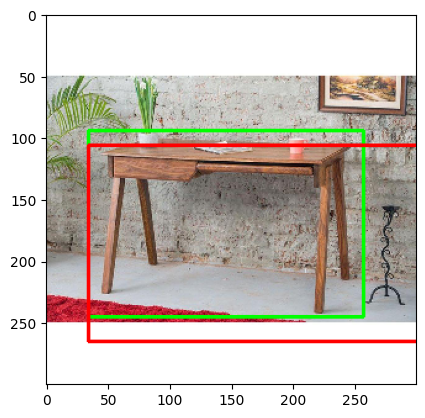

1/1 [==============================] - 0s 46ms/step
TRUE [5.5, 111.25, 286.0, 236.25]
PRED [  5.9186482 112.33068   327.56873   267.1318   ]


1/1 [==============================] - 0s 18ms/step
TRUE [6.0, 81.0, 288.25, 288.25]
PRED [ 16.408104  98.72449  290.3064   239.61102 ]


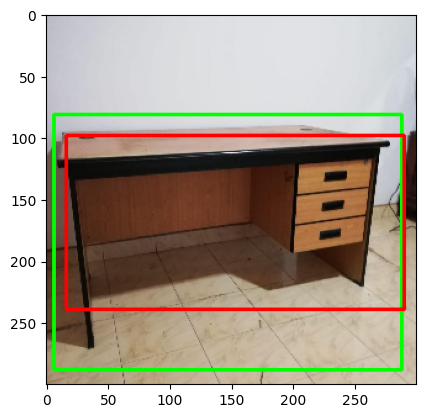

1/1 [==============================] - 0s 19ms/step
TRUE [4.5, 64.25, 299.25, 230.0]
PRED [  2.1761096  75.35739   302.65753   248.13747  ]


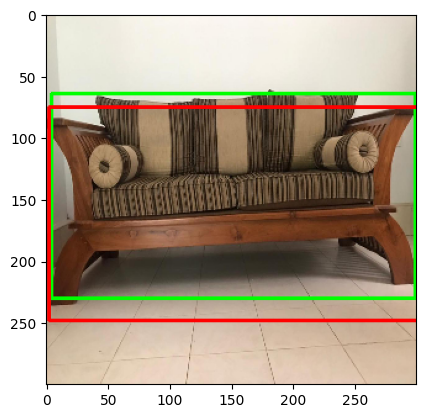

1/1 [==============================] - 0s 23ms/step
TRUE [12.25, 54.25, 278.25, 243.0]
PRED [-17.836266  47.274906 286.61258  232.44789 ]


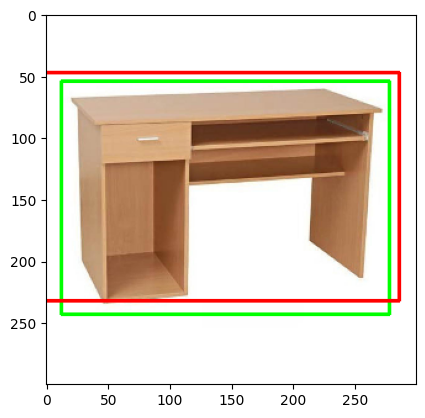

1/1 [==============================] - 0s 21ms/step
TRUE [26.25, 83.0, 272.75, 273.75]
PRED [ 28.611115 103.07832  295.15735  251.60269 ]


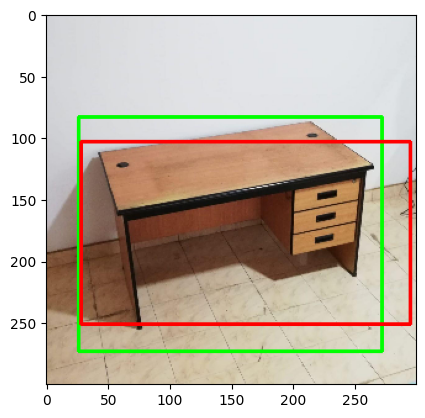

In [49]:
def plot_bounding_boxes(image_array, true_bbox, pred_bbox):
    # Convert image array to uint8 for compatibility with OpenCV
    img = (image_array * 255).astype(np.uint8)

    # True bounding box
    true_xmin, true_ymin, true_xmax, true_ymax = true_bbox
    cv2.rectangle(img, (int(true_xmin), int(true_ymin)), (int(true_xmax), int(true_ymax)), (0, 255, 0), 2)

    # Predicted bounding box
    pred_xmin, pred_ymin, pred_xmax, pred_ymax = pred_bbox
    cv2.rectangle(img, (int(pred_xmin), int(pred_ymin)), (int(pred_xmax), int(pred_ymax)), (255, 0, 0), 2)

    # Invert the y-axis
    # img = cv2.flip(img, 0)

    plt.imshow(img)
    plt.show()

# Function to load and preprocess an image
def load_and_preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(300, 300))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array / 255.0  # Normalize the pixel values to [0, 1]


i = 0
for index, row in valid_annotations.iterrows():
    if i == 10:
        break

    image_path = os.path.join(data_path, 'valid', row['filename'])
    true_bbox = [row['xmin'], row['ymin'], row['xmax'], row['ymax']]

    # Load and preprocess the image
    img_array = load_and_preprocess_image(image_path)
    # print(type(img_array))
    # Predict bounding box
    pred_bbox = model.predict(img_array)[0]

    print("TRUE", true_bbox)
    print("PRED", pred_bbox)

    # Plot true and predicted bounding boxes using img_array
    plot_bounding_boxes(img_array[0], true_bbox, pred_bbox)


    i += 1



# Experiment Conclusion

After a few experiemnts with the following permutations, found that Model #4 + Compile Model #2 works best:

1. Model #1 + Compile Model #1
2. Model #2 + Compile Model #1
3. Model #3 + Compile Model #1
4. Model #4 + Compile Model #1
5. Model #5 + Compile Model #1
5. Model #1 + Compile Model #2
6. Model #2 + Compile Model #2
7. Model #3 + Compile Model #2
8. Model #4 + Compile Model #2
8. Model #5 + Compile Model #2

## Concluded that permutation 8 (Model #4 + Compile Model #2) works best.

Even though Model #5 + Compile Model #2 works as well, it has approximately twice as many parameters which makes it more computationally expensive to train than Model #4 + Compile Model #2.

